<a href="https://colab.research.google.com/github/MPGarg/Session-4/blob/main/EVA8S4E4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Attempt 4:**

Target:
*   Lower number of parameters (Meet our 2nd target of <=8000 Parameters)

Results:
*   Total Parameters: 7,944
*   Best Training Accuracy: 99.21%
*   Best Test Accuracy: 99.46%

Analysis:
*   Model was able to achieve it's target of 99.40% accuracy at 8th epoch with less than 8k parameters and remained more than 99.40% after that.
*   Model Architecture is the same as the previous one but with reduced filter sizes.
*   It trained well and has higher test accuracy than training accuracy across epochs.
*   Even with a lower number of parameters compared to the previous model, it was able to give good results earlier than the previous model!

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Transformations

*   Image Normalization


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std  
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Sample Images

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

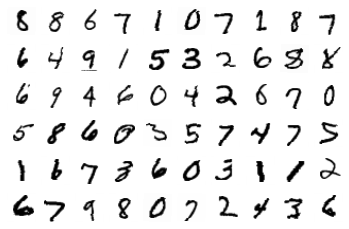

In [5]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

Basic working model with Train & Test Validations

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26 RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 24 RF = 5

        # TRANSITION BLOCK 1        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24 RF = 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 10 RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 8 RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 6 RF = 18

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1 RF = 28

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.dropout(self.convblock1(x))
        x = self.dropout(self.convblock2(x))
        x = self.pool1(self.convblock3(x))
        x = self.dropout(self.convblock4(x))
        x = self.dropout(self.convblock5(x))
        x = self.dropout(self.convblock6(x))
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
       BatchNorm2d-6           [-1, 15, 24, 24]              30
              ReLU-7           [-1, 15, 24, 24]               0
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             150
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
          Dropout-14           [-1

# Training and Testing

We have 7.9k params for this model

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and Test of our model

In [15]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


Loss=0.13514751195907593 Batch_id=468 Accuracy=91.96: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]



Test set: Average loss: 0.0827, Accuracy: 9719/10000 (97.19%)

EPOCH: 2


Loss=0.021033739671111107 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:29<00:00, 15.96it/s]



Test set: Average loss: 0.0373, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.05245283618569374 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:29<00:00, 15.81it/s]



Test set: Average loss: 0.0324, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.03880801424384117 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]



Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.17620642483234406 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]



Test set: Average loss: 0.0291, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.06452054530382156 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]



Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.015975981950759888 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]



Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.03795486316084862 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]



Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.024267271161079407 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.00759374164044857 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]



Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.004552628379315138 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]



Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.009640109725296497 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s]



Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.009532894939184189 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s]



Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.007068181876093149 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:30<00:00, 15.56it/s]



Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.012209084816277027 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s]



Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)



In [16]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

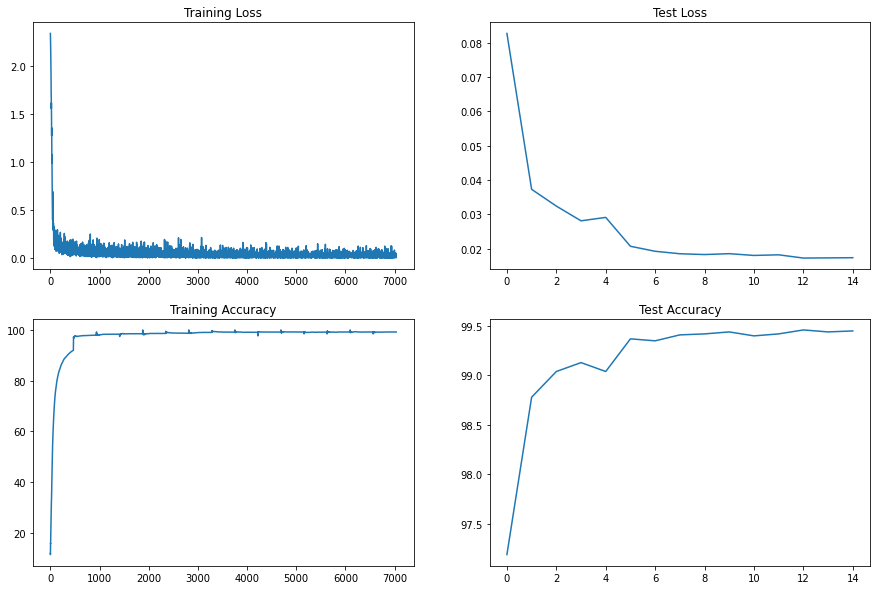

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")